# Chatbot with seq-to-seq architecture

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import numpy as np

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Load preprocessed data

In [2]:
import import_ipynb
from preprocess_data import PAD_token,EOS_token,SOS_token,MAX_LENGTH,voc,pairs,normalizeString,unicodeToAscii

importing Jupyter notebook from preprocess_data.ipynb
b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'

Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Ko

# Prepare Data for Models

In [3]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 125,   70, 2232,   50,  167],
        [1084,  928,    4,   98,  266],
        [1082,   92,    4,    6,    4],
        [  56,  560,    4,    2,    2],
        [  12,    4,    2,    0,    0],
        [   4,    4,    0,    0,    0],
        [   4,    4,    0,    0,    0],
        [   4,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 8, 5, 4, 4])
target_variable: tensor([[ 271,   65,   51,   50,   25],
        [ 117,  132,  411,   98,  200],
        [  36,  380,  115,    6,  544],
        [  12,  159,  791,    2,    4],
        [5964,    4,   40,    0,    4],
        [   6,    4,  746,    0,    4],
        [   2,    4,    4,    0,    2],
        [   0,    2,    4,    0,    0],
        [   0,    0,    4,    0,    0],
        [   0,    0,    2,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  

# Define Models

## Encoder

In [4]:
class EncoderRNN(nn.Module):
    # hidden_size= dimensions of RNN units(how many neurons we have in our hidden layer). Equals to the size of word embeddings
    # embedding = embedding layer, responsible to convert a word index to a dense vector value(word embedding)
    # n_layers = number of layers of the RNN
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    #input_seq: batch of input sentences; shape=(max_length,batch_size) because we use pack_padded_sequences
    #input_lengths:list of sentence lengths corresponding to each sentence in the batch
    #hidden state, of shape: (n_layers x num_directions, batch_size, hidden_size)
    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        #Passes as input the packed input sequence and the initial hidden state
        #Returns two Tensors, one for the output and another for the hidden_state
        #output = contains the output features from the last layer of the GRU for each time step t and for both directions
        #hidden = contains the hidden_state for the last timestep t=seq_len
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs, remember we have two GRUs working together in different directions
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

## Decoder

Define the attention submodule

In [5]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        #The method of attention is the dot_score
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        # hidden of shape: (1,batch_size,hidden_size)
        # encoder_outputs of shape (max_length,batch_size,hidden_size)
        # (1,batch_size,hidden_size) * (max_length,batch_size,hidden_size) = (max_length,batch_size,hidden_size)

        # Calculate the attention weights (energies) based on the given method
        attn_energies = self.dot_score(hidden, encoder_outputs) #(max_length,batch_size)

        # Transpose max_length and batch_size dimensions
        # Because we want to pass it through the softmax function
        attn_energies = attn_energies.t() #(batch_size, max_length)

        # Return the softmax normalized probability score, across the columns, for every batch
        return F.softmax(attn_energies, dim=1).unsqueeze(1) #(batch_size, 1, max_length)  (with added dimension)

Implement the actual decoder model. 
For the decoder, we will manually feed our batch one time step at a time. 
This means that our embedded word tensor and GRU output will both have shape (1, batch_size, hidden_size).

In [6]:
# Inputs:
#     input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)
#     last_hidden: final hidden layer of encoder; shape=(n_layers x num_directions, batch_size, hidden_size)
#     encoder_outputs: encoder model’s output; shape=(max_length, batch_size, hidden_size)

# Outputs:
#     output: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded 
#                 sequence; shape=(batch_size, voc.num_words)
#     hidden: final hidden state of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        #The input_size is the embedding size
        #We dropout only if we have more than one layers
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        # number of inputs = hidden_size * 2
        # number of outputs = hidden_size
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        # hidden_size = the input which is the ouput from the previous linear layer
        # output_size = size of our vocabulary, how many words we want to predict
        self.out = nn.Linear(hidden_size, output_size)

        # Initialize the Attention class
        # attn_model: the name of the Attention operation
        self.attn = Attn(attn_model, hidden_size)

    #input_step: one time step of input sequence of shape (1, batch_size)
    #last_hidden: last hidden state of the encoder model of shape (n_layers*2,batch_size,hidden_size)
    #encoder_outputs: encoder model output of shape (seq_len, batch, 2*hidden_size). seq_len is the max_length
    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (batch of words) at a time. The input of the GRU is (1,batch_size)
        # Get embedding of current input word, or else the features
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
#       pass to the GRU, the embedding input and the last hidden state of the encoder
        #output features from the last GRU of each t, of shape (seq_len,batch,2*hidden_size) where seq_len = 1
        #hidden: the hidden_state for t=seq_len=1 of shape (2*num_layers,batch,hidden_size)
        #Outputs:
        #output features from the last GRU of each t, of shape (seq_len,batch,2*hidden_size) where seq_len = 1
        #the (last)hidden_state for t=seq_len of shape (2*num_layers,batch,hidden_size)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output. Calls the forward method of Attention class
        # encoder_outputs = pass the encoder output to the Attention mechanism
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention outputs to encoder outputs to get new "weighted sum" context vector
        #(batch_size,1,max_length) bmm with (batch_size,max_length,hidden) = (batch_size,1,hidden)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        # Squeeze the output of the current gru at dimension 0; shape of (batch_size, hidden_size)
        rnn_output = rnn_output.squeeze(0)
        # Squeeze the context vector at dimension 1; shape of (batch_size, hidden_size)
        context = context.squeeze(1)
        # Concatenate the rnn_output and context along the columns. The concat_input vector is of shape (batch_size,2*hidden) 
        concat_input = torch.cat((rnn_output, context), 1)
        #We pass the concat_input through the linear layer self.concat, as defined in the init function
        #Then pass it through a tanh function 
        #Outputs a vector of shape (hidden_size)
        concat_output = torch.tanh(self.concat(concat_input))
        # We pass through the last layer and we get a Tensor of shape (batch_size, vocabulary_size)
        output = self.out(concat_output)
        #Take the maximum of the ouput layer, or the prediction
        output = F.softmax(output, dim=1)
        # Return the predicted output and the final hidden state of the current timestep 
        # The current output and hidden state will then be passed to the next timestep
        return output, hidden

# Define Training Procedure

Masked loss

Since we are dealing with batches of padded sequences, we cannot simply consider all elements of the tensor when calculating loss. We define maskNLLLoss to calculate our loss based on our decoder’s output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor. This loss function calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor.

In [7]:
#inp: the output of the decoder
#
#mask: a Tensor that represents the elements that are present and the zero elements; (maximum_length, batch_size)
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum() #calculate how many non-zero elements we should consider
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

## Run Training

In [8]:
# One train iteration

def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward the input sequence to the encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Forward batch of sequences through decoder one time step at a time
    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        # Teacher forcing: next input is current target
        decoder_input = target_variable[t].view(1, -1)
        # Calculate and accumulate loss
        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [9]:
# Build encoder and decoder ...
model_name = 'cb_model'
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

print('Building encoder and decoder ...')
#Define the embedding layer with the numbers of all words 
#and the dimension of the embedding(how many values in a word representation)
embedding = nn.Embedding(voc.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

#Ensure dropout layers are in train mode
#We must tell Pytorch that we are in train mode(not test)
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

# Run training iterations
# Load batches for each iteration
training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                  for _ in range(n_iteration)]

# Initializations
start_iteration = 1
print_loss = 0
plot_every=100
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

# Training loop
print("Start training...")
for iteration in range(start_iteration, n_iteration + 1):
    training_batch = training_batches[iteration - 1]
    # Extract fields from batch
    input_variable, lengths, target_variable, mask, max_target_len = training_batch

    # Run a training iteration with batch
    loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                 decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
    print_loss += loss
    plot_loss_total += loss

    # Print progress
    if iteration % print_every == 0:
        print_loss_avg = print_loss / print_every
        print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
        print_loss = 0
        
    if iteration % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

Building encoder and decoder ...
Building optimizers ...
Start training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9658
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8598
Iteration: 3; Percent complete: 0.1%; Average loss: 8.6476
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3016
Iteration: 5; Percent complete: 0.1%; Average loss: 7.8980
Iteration: 6; Percent complete: 0.1%; Average loss: 7.3293
Iteration: 7; Percent complete: 0.2%; Average loss: 6.8914
Iteration: 8; Percent complete: 0.2%; Average loss: 6.7516
Iteration: 9; Percent complete: 0.2%; Average loss: 6.7438
Iteration: 10; Percent complete: 0.2%; Average loss: 6.4509
Iteration: 11; Percent complete: 0.3%; Average loss: 6.2345
Iteration: 12; Percent complete: 0.3%; Average loss: 5.9655
Iteration: 13; Percent complete: 0.3%; Average loss: 5.8671
Iteration: 14; Percent complete: 0.4%; Average loss: 5.5407
Iteration: 15; Percent complete: 0.4%; Average loss: 5.6154
Iteration: 16; Percent complete: 0

Iteration: 136; Percent complete: 3.4%; Average loss: 4.1478
Iteration: 137; Percent complete: 3.4%; Average loss: 4.3027
Iteration: 138; Percent complete: 3.5%; Average loss: 4.0695
Iteration: 139; Percent complete: 3.5%; Average loss: 4.3788
Iteration: 140; Percent complete: 3.5%; Average loss: 4.2439
Iteration: 141; Percent complete: 3.5%; Average loss: 4.2438
Iteration: 142; Percent complete: 3.5%; Average loss: 4.4115
Iteration: 143; Percent complete: 3.6%; Average loss: 4.2959
Iteration: 144; Percent complete: 3.6%; Average loss: 4.1394
Iteration: 145; Percent complete: 3.6%; Average loss: 4.4122
Iteration: 146; Percent complete: 3.6%; Average loss: 4.6459
Iteration: 147; Percent complete: 3.7%; Average loss: 4.2017
Iteration: 148; Percent complete: 3.7%; Average loss: 4.3309
Iteration: 149; Percent complete: 3.7%; Average loss: 4.2333
Iteration: 150; Percent complete: 3.8%; Average loss: 4.2155
Iteration: 151; Percent complete: 3.8%; Average loss: 4.2460
Iteration: 152; Percent 

Iteration: 271; Percent complete: 6.8%; Average loss: 3.7554
Iteration: 272; Percent complete: 6.8%; Average loss: 4.1646
Iteration: 273; Percent complete: 6.8%; Average loss: 3.6579
Iteration: 274; Percent complete: 6.9%; Average loss: 3.7817
Iteration: 275; Percent complete: 6.9%; Average loss: 3.8380
Iteration: 276; Percent complete: 6.9%; Average loss: 4.0042
Iteration: 277; Percent complete: 6.9%; Average loss: 3.8533
Iteration: 278; Percent complete: 7.0%; Average loss: 3.8429
Iteration: 279; Percent complete: 7.0%; Average loss: 3.6628
Iteration: 280; Percent complete: 7.0%; Average loss: 3.8653
Iteration: 281; Percent complete: 7.0%; Average loss: 4.2695
Iteration: 282; Percent complete: 7.0%; Average loss: 4.2135
Iteration: 283; Percent complete: 7.1%; Average loss: 3.7009
Iteration: 284; Percent complete: 7.1%; Average loss: 4.1353
Iteration: 285; Percent complete: 7.1%; Average loss: 3.8052
Iteration: 286; Percent complete: 7.1%; Average loss: 3.7937
Iteration: 287; Percent 

Iteration: 406; Percent complete: 10.2%; Average loss: 3.8579
Iteration: 407; Percent complete: 10.2%; Average loss: 3.8259
Iteration: 408; Percent complete: 10.2%; Average loss: 3.7080
Iteration: 409; Percent complete: 10.2%; Average loss: 3.7757
Iteration: 410; Percent complete: 10.2%; Average loss: 3.5780
Iteration: 411; Percent complete: 10.3%; Average loss: 3.7111
Iteration: 412; Percent complete: 10.3%; Average loss: 3.7451
Iteration: 413; Percent complete: 10.3%; Average loss: 3.8583
Iteration: 414; Percent complete: 10.3%; Average loss: 4.1756
Iteration: 415; Percent complete: 10.4%; Average loss: 3.8249
Iteration: 416; Percent complete: 10.4%; Average loss: 3.6432
Iteration: 417; Percent complete: 10.4%; Average loss: 3.9082
Iteration: 418; Percent complete: 10.4%; Average loss: 3.8503
Iteration: 419; Percent complete: 10.5%; Average loss: 3.7670
Iteration: 420; Percent complete: 10.5%; Average loss: 3.7742
Iteration: 421; Percent complete: 10.5%; Average loss: 3.8294
Iteratio

Iteration: 539; Percent complete: 13.5%; Average loss: 3.6266
Iteration: 540; Percent complete: 13.5%; Average loss: 3.7652
Iteration: 541; Percent complete: 13.5%; Average loss: 3.8103
Iteration: 542; Percent complete: 13.6%; Average loss: 3.7531
Iteration: 543; Percent complete: 13.6%; Average loss: 3.6878
Iteration: 544; Percent complete: 13.6%; Average loss: 3.5577
Iteration: 545; Percent complete: 13.6%; Average loss: 3.5720
Iteration: 546; Percent complete: 13.7%; Average loss: 3.6161
Iteration: 547; Percent complete: 13.7%; Average loss: 3.5513
Iteration: 548; Percent complete: 13.7%; Average loss: 3.5902
Iteration: 549; Percent complete: 13.7%; Average loss: 3.7634
Iteration: 550; Percent complete: 13.8%; Average loss: 3.6447
Iteration: 551; Percent complete: 13.8%; Average loss: 3.4412
Iteration: 552; Percent complete: 13.8%; Average loss: 3.8647
Iteration: 553; Percent complete: 13.8%; Average loss: 3.5238
Iteration: 554; Percent complete: 13.9%; Average loss: 3.6314
Iteratio

Iteration: 672; Percent complete: 16.8%; Average loss: 3.7227
Iteration: 673; Percent complete: 16.8%; Average loss: 3.4789
Iteration: 674; Percent complete: 16.9%; Average loss: 3.4753
Iteration: 675; Percent complete: 16.9%; Average loss: 3.5976
Iteration: 676; Percent complete: 16.9%; Average loss: 3.6252
Iteration: 677; Percent complete: 16.9%; Average loss: 3.5403
Iteration: 678; Percent complete: 17.0%; Average loss: 3.3551
Iteration: 679; Percent complete: 17.0%; Average loss: 3.7152
Iteration: 680; Percent complete: 17.0%; Average loss: 3.5846
Iteration: 681; Percent complete: 17.0%; Average loss: 3.8249
Iteration: 682; Percent complete: 17.1%; Average loss: 3.7975
Iteration: 683; Percent complete: 17.1%; Average loss: 3.4466
Iteration: 684; Percent complete: 17.1%; Average loss: 3.4692
Iteration: 685; Percent complete: 17.1%; Average loss: 3.6723
Iteration: 686; Percent complete: 17.2%; Average loss: 3.6272
Iteration: 687; Percent complete: 17.2%; Average loss: 3.6558
Iteratio

Iteration: 805; Percent complete: 20.1%; Average loss: 3.8299
Iteration: 806; Percent complete: 20.2%; Average loss: 3.7206
Iteration: 807; Percent complete: 20.2%; Average loss: 3.5211
Iteration: 808; Percent complete: 20.2%; Average loss: 3.7262
Iteration: 809; Percent complete: 20.2%; Average loss: 3.8923
Iteration: 810; Percent complete: 20.2%; Average loss: 3.5474
Iteration: 811; Percent complete: 20.3%; Average loss: 3.5444
Iteration: 812; Percent complete: 20.3%; Average loss: 3.6222
Iteration: 813; Percent complete: 20.3%; Average loss: 3.5294
Iteration: 814; Percent complete: 20.3%; Average loss: 3.4444
Iteration: 815; Percent complete: 20.4%; Average loss: 3.6107
Iteration: 816; Percent complete: 20.4%; Average loss: 3.6179
Iteration: 817; Percent complete: 20.4%; Average loss: 3.6023
Iteration: 818; Percent complete: 20.4%; Average loss: 3.5720
Iteration: 819; Percent complete: 20.5%; Average loss: 3.7683
Iteration: 820; Percent complete: 20.5%; Average loss: 3.6322
Iteratio

Iteration: 938; Percent complete: 23.4%; Average loss: 3.6067
Iteration: 939; Percent complete: 23.5%; Average loss: 3.3224
Iteration: 940; Percent complete: 23.5%; Average loss: 3.6369
Iteration: 941; Percent complete: 23.5%; Average loss: 3.3779
Iteration: 942; Percent complete: 23.5%; Average loss: 3.5972
Iteration: 943; Percent complete: 23.6%; Average loss: 3.5595
Iteration: 944; Percent complete: 23.6%; Average loss: 3.5478
Iteration: 945; Percent complete: 23.6%; Average loss: 3.4292
Iteration: 946; Percent complete: 23.6%; Average loss: 3.9898
Iteration: 947; Percent complete: 23.7%; Average loss: 3.5132
Iteration: 948; Percent complete: 23.7%; Average loss: 3.4782
Iteration: 949; Percent complete: 23.7%; Average loss: 3.6193
Iteration: 950; Percent complete: 23.8%; Average loss: 3.3950
Iteration: 951; Percent complete: 23.8%; Average loss: 3.5913
Iteration: 952; Percent complete: 23.8%; Average loss: 3.8583
Iteration: 953; Percent complete: 23.8%; Average loss: 3.6561
Iteratio

Iteration: 1070; Percent complete: 26.8%; Average loss: 3.6261
Iteration: 1071; Percent complete: 26.8%; Average loss: 3.6970
Iteration: 1072; Percent complete: 26.8%; Average loss: 3.3390
Iteration: 1073; Percent complete: 26.8%; Average loss: 3.4645
Iteration: 1074; Percent complete: 26.9%; Average loss: 3.1721
Iteration: 1075; Percent complete: 26.9%; Average loss: 3.4620
Iteration: 1076; Percent complete: 26.9%; Average loss: 3.3517
Iteration: 1077; Percent complete: 26.9%; Average loss: 3.1641
Iteration: 1078; Percent complete: 27.0%; Average loss: 3.5599
Iteration: 1079; Percent complete: 27.0%; Average loss: 3.2731
Iteration: 1080; Percent complete: 27.0%; Average loss: 3.6406
Iteration: 1081; Percent complete: 27.0%; Average loss: 3.3268
Iteration: 1082; Percent complete: 27.1%; Average loss: 3.2524
Iteration: 1083; Percent complete: 27.1%; Average loss: 3.3944
Iteration: 1084; Percent complete: 27.1%; Average loss: 3.5636
Iteration: 1085; Percent complete: 27.1%; Average loss:

Iteration: 1201; Percent complete: 30.0%; Average loss: 3.4723
Iteration: 1202; Percent complete: 30.0%; Average loss: 3.3069
Iteration: 1203; Percent complete: 30.1%; Average loss: 3.5066
Iteration: 1204; Percent complete: 30.1%; Average loss: 3.5133
Iteration: 1205; Percent complete: 30.1%; Average loss: 3.5185
Iteration: 1206; Percent complete: 30.1%; Average loss: 3.4443
Iteration: 1207; Percent complete: 30.2%; Average loss: 3.1745
Iteration: 1208; Percent complete: 30.2%; Average loss: 3.2841
Iteration: 1209; Percent complete: 30.2%; Average loss: 3.3563
Iteration: 1210; Percent complete: 30.2%; Average loss: 3.3961
Iteration: 1211; Percent complete: 30.3%; Average loss: 3.4476
Iteration: 1212; Percent complete: 30.3%; Average loss: 3.6580
Iteration: 1213; Percent complete: 30.3%; Average loss: 3.4642
Iteration: 1214; Percent complete: 30.3%; Average loss: 3.4000
Iteration: 1215; Percent complete: 30.4%; Average loss: 3.2677
Iteration: 1216; Percent complete: 30.4%; Average loss:

Iteration: 1332; Percent complete: 33.3%; Average loss: 3.2070
Iteration: 1333; Percent complete: 33.3%; Average loss: 3.4088
Iteration: 1334; Percent complete: 33.4%; Average loss: 3.1845
Iteration: 1335; Percent complete: 33.4%; Average loss: 3.3783
Iteration: 1336; Percent complete: 33.4%; Average loss: 3.2016
Iteration: 1337; Percent complete: 33.4%; Average loss: 3.6589
Iteration: 1338; Percent complete: 33.5%; Average loss: 3.6166
Iteration: 1339; Percent complete: 33.5%; Average loss: 3.1081
Iteration: 1340; Percent complete: 33.5%; Average loss: 3.4192
Iteration: 1341; Percent complete: 33.5%; Average loss: 3.5346
Iteration: 1342; Percent complete: 33.6%; Average loss: 3.2695
Iteration: 1343; Percent complete: 33.6%; Average loss: 3.6893
Iteration: 1344; Percent complete: 33.6%; Average loss: 3.6481
Iteration: 1345; Percent complete: 33.6%; Average loss: 3.5073
Iteration: 1346; Percent complete: 33.7%; Average loss: 3.4665
Iteration: 1347; Percent complete: 33.7%; Average loss:

Iteration: 1463; Percent complete: 36.6%; Average loss: 3.2602
Iteration: 1464; Percent complete: 36.6%; Average loss: 3.3051
Iteration: 1465; Percent complete: 36.6%; Average loss: 3.3033
Iteration: 1466; Percent complete: 36.6%; Average loss: 3.1984
Iteration: 1467; Percent complete: 36.7%; Average loss: 3.0137
Iteration: 1468; Percent complete: 36.7%; Average loss: 3.3163
Iteration: 1469; Percent complete: 36.7%; Average loss: 3.3327
Iteration: 1470; Percent complete: 36.8%; Average loss: 3.5476
Iteration: 1471; Percent complete: 36.8%; Average loss: 3.2608
Iteration: 1472; Percent complete: 36.8%; Average loss: 3.3738
Iteration: 1473; Percent complete: 36.8%; Average loss: 3.4061
Iteration: 1474; Percent complete: 36.9%; Average loss: 3.0831
Iteration: 1475; Percent complete: 36.9%; Average loss: 3.2011
Iteration: 1476; Percent complete: 36.9%; Average loss: 3.1973
Iteration: 1477; Percent complete: 36.9%; Average loss: 3.0908
Iteration: 1478; Percent complete: 37.0%; Average loss:

Iteration: 1594; Percent complete: 39.9%; Average loss: 3.1962
Iteration: 1595; Percent complete: 39.9%; Average loss: 3.1374
Iteration: 1596; Percent complete: 39.9%; Average loss: 3.2080
Iteration: 1597; Percent complete: 39.9%; Average loss: 3.2819
Iteration: 1598; Percent complete: 40.0%; Average loss: 3.1762
Iteration: 1599; Percent complete: 40.0%; Average loss: 3.4148
Iteration: 1600; Percent complete: 40.0%; Average loss: 3.1129
Iteration: 1601; Percent complete: 40.0%; Average loss: 3.4291
Iteration: 1602; Percent complete: 40.1%; Average loss: 3.3510
Iteration: 1603; Percent complete: 40.1%; Average loss: 3.6000
Iteration: 1604; Percent complete: 40.1%; Average loss: 3.1611
Iteration: 1605; Percent complete: 40.1%; Average loss: 3.0778
Iteration: 1606; Percent complete: 40.2%; Average loss: 3.3119
Iteration: 1607; Percent complete: 40.2%; Average loss: 3.3228
Iteration: 1608; Percent complete: 40.2%; Average loss: 3.2556
Iteration: 1609; Percent complete: 40.2%; Average loss:

Iteration: 1725; Percent complete: 43.1%; Average loss: 3.0773
Iteration: 1726; Percent complete: 43.1%; Average loss: 3.3158
Iteration: 1727; Percent complete: 43.2%; Average loss: 3.0779
Iteration: 1728; Percent complete: 43.2%; Average loss: 3.3792
Iteration: 1729; Percent complete: 43.2%; Average loss: 3.2198
Iteration: 1730; Percent complete: 43.2%; Average loss: 3.5250
Iteration: 1731; Percent complete: 43.3%; Average loss: 3.4832
Iteration: 1732; Percent complete: 43.3%; Average loss: 3.4652
Iteration: 1733; Percent complete: 43.3%; Average loss: 3.2622
Iteration: 1734; Percent complete: 43.4%; Average loss: 3.3962
Iteration: 1735; Percent complete: 43.4%; Average loss: 3.1992
Iteration: 1736; Percent complete: 43.4%; Average loss: 3.1623
Iteration: 1737; Percent complete: 43.4%; Average loss: 3.2174
Iteration: 1738; Percent complete: 43.5%; Average loss: 3.3069
Iteration: 1739; Percent complete: 43.5%; Average loss: 3.5121
Iteration: 1740; Percent complete: 43.5%; Average loss:

Iteration: 1856; Percent complete: 46.4%; Average loss: 3.4051
Iteration: 1857; Percent complete: 46.4%; Average loss: 3.3804
Iteration: 1858; Percent complete: 46.5%; Average loss: 3.4150
Iteration: 1859; Percent complete: 46.5%; Average loss: 3.0378
Iteration: 1860; Percent complete: 46.5%; Average loss: 3.3651
Iteration: 1861; Percent complete: 46.5%; Average loss: 3.0540
Iteration: 1862; Percent complete: 46.6%; Average loss: 3.2142
Iteration: 1863; Percent complete: 46.6%; Average loss: 3.2898
Iteration: 1864; Percent complete: 46.6%; Average loss: 3.4082
Iteration: 1865; Percent complete: 46.6%; Average loss: 3.2999
Iteration: 1866; Percent complete: 46.7%; Average loss: 3.2113
Iteration: 1867; Percent complete: 46.7%; Average loss: 3.2513
Iteration: 1868; Percent complete: 46.7%; Average loss: 3.5262
Iteration: 1869; Percent complete: 46.7%; Average loss: 3.2026
Iteration: 1870; Percent complete: 46.8%; Average loss: 3.1099
Iteration: 1871; Percent complete: 46.8%; Average loss:

Iteration: 1987; Percent complete: 49.7%; Average loss: 3.0918
Iteration: 1988; Percent complete: 49.7%; Average loss: 3.0144
Iteration: 1989; Percent complete: 49.7%; Average loss: 3.1827
Iteration: 1990; Percent complete: 49.8%; Average loss: 3.4217
Iteration: 1991; Percent complete: 49.8%; Average loss: 3.1985
Iteration: 1992; Percent complete: 49.8%; Average loss: 2.9406
Iteration: 1993; Percent complete: 49.8%; Average loss: 3.3257
Iteration: 1994; Percent complete: 49.9%; Average loss: 3.3965
Iteration: 1995; Percent complete: 49.9%; Average loss: 3.1958
Iteration: 1996; Percent complete: 49.9%; Average loss: 3.2788
Iteration: 1997; Percent complete: 49.9%; Average loss: 3.1909
Iteration: 1998; Percent complete: 50.0%; Average loss: 3.2938
Iteration: 1999; Percent complete: 50.0%; Average loss: 3.1639
Iteration: 2000; Percent complete: 50.0%; Average loss: 3.1567
Iteration: 2001; Percent complete: 50.0%; Average loss: 3.2105
Iteration: 2002; Percent complete: 50.0%; Average loss:

Iteration: 2118; Percent complete: 52.9%; Average loss: 3.0589
Iteration: 2119; Percent complete: 53.0%; Average loss: 3.0773
Iteration: 2120; Percent complete: 53.0%; Average loss: 3.1167
Iteration: 2121; Percent complete: 53.0%; Average loss: 2.9783
Iteration: 2122; Percent complete: 53.0%; Average loss: 3.1659
Iteration: 2123; Percent complete: 53.1%; Average loss: 3.0772
Iteration: 2124; Percent complete: 53.1%; Average loss: 3.1320
Iteration: 2125; Percent complete: 53.1%; Average loss: 3.0404
Iteration: 2126; Percent complete: 53.1%; Average loss: 2.9546
Iteration: 2127; Percent complete: 53.2%; Average loss: 3.0509
Iteration: 2128; Percent complete: 53.2%; Average loss: 3.0536
Iteration: 2129; Percent complete: 53.2%; Average loss: 2.9325
Iteration: 2130; Percent complete: 53.2%; Average loss: 3.2936
Iteration: 2131; Percent complete: 53.3%; Average loss: 3.5222
Iteration: 2132; Percent complete: 53.3%; Average loss: 3.1539
Iteration: 2133; Percent complete: 53.3%; Average loss:

Iteration: 2249; Percent complete: 56.2%; Average loss: 3.0891
Iteration: 2250; Percent complete: 56.2%; Average loss: 2.9149
Iteration: 2251; Percent complete: 56.3%; Average loss: 3.3136
Iteration: 2252; Percent complete: 56.3%; Average loss: 3.0285
Iteration: 2253; Percent complete: 56.3%; Average loss: 3.1245
Iteration: 2254; Percent complete: 56.4%; Average loss: 3.2574
Iteration: 2255; Percent complete: 56.4%; Average loss: 2.9540
Iteration: 2256; Percent complete: 56.4%; Average loss: 3.0743
Iteration: 2257; Percent complete: 56.4%; Average loss: 2.8043
Iteration: 2258; Percent complete: 56.5%; Average loss: 3.3215
Iteration: 2259; Percent complete: 56.5%; Average loss: 3.2710
Iteration: 2260; Percent complete: 56.5%; Average loss: 2.9548
Iteration: 2261; Percent complete: 56.5%; Average loss: 3.1347
Iteration: 2262; Percent complete: 56.5%; Average loss: 3.1737
Iteration: 2263; Percent complete: 56.6%; Average loss: 3.0570
Iteration: 2264; Percent complete: 56.6%; Average loss:

Iteration: 2380; Percent complete: 59.5%; Average loss: 3.0373
Iteration: 2381; Percent complete: 59.5%; Average loss: 2.9803
Iteration: 2382; Percent complete: 59.6%; Average loss: 3.2362
Iteration: 2383; Percent complete: 59.6%; Average loss: 3.0512
Iteration: 2384; Percent complete: 59.6%; Average loss: 2.9372
Iteration: 2385; Percent complete: 59.6%; Average loss: 2.9225
Iteration: 2386; Percent complete: 59.7%; Average loss: 3.1324
Iteration: 2387; Percent complete: 59.7%; Average loss: 3.1131
Iteration: 2388; Percent complete: 59.7%; Average loss: 3.3019
Iteration: 2389; Percent complete: 59.7%; Average loss: 2.9457
Iteration: 2390; Percent complete: 59.8%; Average loss: 3.1870
Iteration: 2391; Percent complete: 59.8%; Average loss: 3.0099
Iteration: 2392; Percent complete: 59.8%; Average loss: 2.8515
Iteration: 2393; Percent complete: 59.8%; Average loss: 2.9133
Iteration: 2394; Percent complete: 59.9%; Average loss: 2.9414
Iteration: 2395; Percent complete: 59.9%; Average loss:

Iteration: 2511; Percent complete: 62.8%; Average loss: 2.8370
Iteration: 2512; Percent complete: 62.8%; Average loss: 2.9543
Iteration: 2513; Percent complete: 62.8%; Average loss: 3.0609
Iteration: 2514; Percent complete: 62.8%; Average loss: 3.0859
Iteration: 2515; Percent complete: 62.9%; Average loss: 3.0983
Iteration: 2516; Percent complete: 62.9%; Average loss: 3.2278
Iteration: 2517; Percent complete: 62.9%; Average loss: 3.0785
Iteration: 2518; Percent complete: 62.9%; Average loss: 2.7791
Iteration: 2519; Percent complete: 63.0%; Average loss: 3.0249
Iteration: 2520; Percent complete: 63.0%; Average loss: 3.0103
Iteration: 2521; Percent complete: 63.0%; Average loss: 3.0210
Iteration: 2522; Percent complete: 63.0%; Average loss: 2.8216
Iteration: 2523; Percent complete: 63.1%; Average loss: 2.7464
Iteration: 2524; Percent complete: 63.1%; Average loss: 2.8507
Iteration: 2525; Percent complete: 63.1%; Average loss: 2.8738
Iteration: 2526; Percent complete: 63.1%; Average loss:

Iteration: 2642; Percent complete: 66.0%; Average loss: 2.8968
Iteration: 2643; Percent complete: 66.1%; Average loss: 2.9378
Iteration: 2644; Percent complete: 66.1%; Average loss: 2.7883
Iteration: 2645; Percent complete: 66.1%; Average loss: 3.2221
Iteration: 2646; Percent complete: 66.1%; Average loss: 3.0165
Iteration: 2647; Percent complete: 66.2%; Average loss: 2.8748
Iteration: 2648; Percent complete: 66.2%; Average loss: 3.0814
Iteration: 2649; Percent complete: 66.2%; Average loss: 2.7682
Iteration: 2650; Percent complete: 66.2%; Average loss: 2.9862
Iteration: 2651; Percent complete: 66.3%; Average loss: 2.8564
Iteration: 2652; Percent complete: 66.3%; Average loss: 2.8629
Iteration: 2653; Percent complete: 66.3%; Average loss: 2.7799
Iteration: 2654; Percent complete: 66.3%; Average loss: 3.0210
Iteration: 2655; Percent complete: 66.4%; Average loss: 2.9106
Iteration: 2656; Percent complete: 66.4%; Average loss: 2.8327
Iteration: 2657; Percent complete: 66.4%; Average loss:

Iteration: 2773; Percent complete: 69.3%; Average loss: 2.9191
Iteration: 2774; Percent complete: 69.3%; Average loss: 2.9652
Iteration: 2775; Percent complete: 69.4%; Average loss: 2.7541
Iteration: 2776; Percent complete: 69.4%; Average loss: 3.0785
Iteration: 2777; Percent complete: 69.4%; Average loss: 3.2959
Iteration: 2778; Percent complete: 69.5%; Average loss: 2.9444
Iteration: 2779; Percent complete: 69.5%; Average loss: 2.9437
Iteration: 2780; Percent complete: 69.5%; Average loss: 3.1793
Iteration: 2781; Percent complete: 69.5%; Average loss: 2.9310
Iteration: 2782; Percent complete: 69.5%; Average loss: 3.2484
Iteration: 2783; Percent complete: 69.6%; Average loss: 2.9711
Iteration: 2784; Percent complete: 69.6%; Average loss: 3.1230
Iteration: 2785; Percent complete: 69.6%; Average loss: 2.9427
Iteration: 2786; Percent complete: 69.7%; Average loss: 2.6955
Iteration: 2787; Percent complete: 69.7%; Average loss: 2.9494
Iteration: 2788; Percent complete: 69.7%; Average loss:

Iteration: 2904; Percent complete: 72.6%; Average loss: 2.8774
Iteration: 2905; Percent complete: 72.6%; Average loss: 3.1948
Iteration: 2906; Percent complete: 72.7%; Average loss: 2.8562
Iteration: 2907; Percent complete: 72.7%; Average loss: 3.2715
Iteration: 2908; Percent complete: 72.7%; Average loss: 2.7998
Iteration: 2909; Percent complete: 72.7%; Average loss: 3.0485
Iteration: 2910; Percent complete: 72.8%; Average loss: 3.0846
Iteration: 2911; Percent complete: 72.8%; Average loss: 2.8564
Iteration: 2912; Percent complete: 72.8%; Average loss: 2.9801
Iteration: 2913; Percent complete: 72.8%; Average loss: 2.7658
Iteration: 2914; Percent complete: 72.9%; Average loss: 2.7819
Iteration: 2915; Percent complete: 72.9%; Average loss: 2.8179
Iteration: 2916; Percent complete: 72.9%; Average loss: 2.9353
Iteration: 2917; Percent complete: 72.9%; Average loss: 2.7145
Iteration: 2918; Percent complete: 73.0%; Average loss: 2.8316
Iteration: 2919; Percent complete: 73.0%; Average loss:

Iteration: 3035; Percent complete: 75.9%; Average loss: 3.0693
Iteration: 3036; Percent complete: 75.9%; Average loss: 2.8184
Iteration: 3037; Percent complete: 75.9%; Average loss: 2.8489
Iteration: 3038; Percent complete: 75.9%; Average loss: 2.8716
Iteration: 3039; Percent complete: 76.0%; Average loss: 2.8567
Iteration: 3040; Percent complete: 76.0%; Average loss: 2.8365
Iteration: 3041; Percent complete: 76.0%; Average loss: 2.8925
Iteration: 3042; Percent complete: 76.0%; Average loss: 2.8681
Iteration: 3043; Percent complete: 76.1%; Average loss: 2.7007
Iteration: 3044; Percent complete: 76.1%; Average loss: 2.8374
Iteration: 3045; Percent complete: 76.1%; Average loss: 2.9807
Iteration: 3046; Percent complete: 76.1%; Average loss: 2.7585
Iteration: 3047; Percent complete: 76.2%; Average loss: 2.8814
Iteration: 3048; Percent complete: 76.2%; Average loss: 3.0024
Iteration: 3049; Percent complete: 76.2%; Average loss: 2.8951
Iteration: 3050; Percent complete: 76.2%; Average loss:

Iteration: 3166; Percent complete: 79.1%; Average loss: 2.6233
Iteration: 3167; Percent complete: 79.2%; Average loss: 2.8885
Iteration: 3168; Percent complete: 79.2%; Average loss: 2.7714
Iteration: 3169; Percent complete: 79.2%; Average loss: 2.8040
Iteration: 3170; Percent complete: 79.2%; Average loss: 2.8386
Iteration: 3171; Percent complete: 79.3%; Average loss: 2.8832
Iteration: 3172; Percent complete: 79.3%; Average loss: 3.0502
Iteration: 3173; Percent complete: 79.3%; Average loss: 2.9459
Iteration: 3174; Percent complete: 79.3%; Average loss: 2.9150
Iteration: 3175; Percent complete: 79.4%; Average loss: 2.9258
Iteration: 3176; Percent complete: 79.4%; Average loss: 2.9414
Iteration: 3177; Percent complete: 79.4%; Average loss: 2.6248
Iteration: 3178; Percent complete: 79.5%; Average loss: 2.9654
Iteration: 3179; Percent complete: 79.5%; Average loss: 3.0498
Iteration: 3180; Percent complete: 79.5%; Average loss: 2.7537
Iteration: 3181; Percent complete: 79.5%; Average loss:

Iteration: 3297; Percent complete: 82.4%; Average loss: 2.8581
Iteration: 3298; Percent complete: 82.5%; Average loss: 2.7916
Iteration: 3299; Percent complete: 82.5%; Average loss: 2.8000
Iteration: 3300; Percent complete: 82.5%; Average loss: 2.9181
Iteration: 3301; Percent complete: 82.5%; Average loss: 2.8273
Iteration: 3302; Percent complete: 82.5%; Average loss: 2.4854
Iteration: 3303; Percent complete: 82.6%; Average loss: 2.9114
Iteration: 3304; Percent complete: 82.6%; Average loss: 2.7591
Iteration: 3305; Percent complete: 82.6%; Average loss: 2.9251
Iteration: 3306; Percent complete: 82.7%; Average loss: 2.8103
Iteration: 3307; Percent complete: 82.7%; Average loss: 2.7248
Iteration: 3308; Percent complete: 82.7%; Average loss: 2.8115
Iteration: 3309; Percent complete: 82.7%; Average loss: 2.9646
Iteration: 3310; Percent complete: 82.8%; Average loss: 2.6974
Iteration: 3311; Percent complete: 82.8%; Average loss: 2.7856
Iteration: 3312; Percent complete: 82.8%; Average loss:

Iteration: 3428; Percent complete: 85.7%; Average loss: 2.8613
Iteration: 3429; Percent complete: 85.7%; Average loss: 2.8172
Iteration: 3430; Percent complete: 85.8%; Average loss: 2.6924
Iteration: 3431; Percent complete: 85.8%; Average loss: 2.7434
Iteration: 3432; Percent complete: 85.8%; Average loss: 2.8465
Iteration: 3433; Percent complete: 85.8%; Average loss: 2.6841
Iteration: 3434; Percent complete: 85.9%; Average loss: 2.6112
Iteration: 3435; Percent complete: 85.9%; Average loss: 2.8932
Iteration: 3436; Percent complete: 85.9%; Average loss: 2.9534
Iteration: 3437; Percent complete: 85.9%; Average loss: 2.9005
Iteration: 3438; Percent complete: 86.0%; Average loss: 2.9642
Iteration: 3439; Percent complete: 86.0%; Average loss: 2.9802
Iteration: 3440; Percent complete: 86.0%; Average loss: 2.7969
Iteration: 3441; Percent complete: 86.0%; Average loss: 2.7144
Iteration: 3442; Percent complete: 86.1%; Average loss: 2.7181
Iteration: 3443; Percent complete: 86.1%; Average loss:

Iteration: 3559; Percent complete: 89.0%; Average loss: 2.6859
Iteration: 3560; Percent complete: 89.0%; Average loss: 2.7282
Iteration: 3561; Percent complete: 89.0%; Average loss: 2.8146
Iteration: 3562; Percent complete: 89.0%; Average loss: 2.6646
Iteration: 3563; Percent complete: 89.1%; Average loss: 2.8127
Iteration: 3564; Percent complete: 89.1%; Average loss: 2.7928
Iteration: 3565; Percent complete: 89.1%; Average loss: 2.9728
Iteration: 3566; Percent complete: 89.1%; Average loss: 2.7407
Iteration: 3567; Percent complete: 89.2%; Average loss: 2.9226
Iteration: 3568; Percent complete: 89.2%; Average loss: 2.7542
Iteration: 3569; Percent complete: 89.2%; Average loss: 2.7778
Iteration: 3570; Percent complete: 89.2%; Average loss: 2.8524
Iteration: 3571; Percent complete: 89.3%; Average loss: 2.8386
Iteration: 3572; Percent complete: 89.3%; Average loss: 2.8125
Iteration: 3573; Percent complete: 89.3%; Average loss: 2.6378
Iteration: 3574; Percent complete: 89.3%; Average loss:

Iteration: 3690; Percent complete: 92.2%; Average loss: 2.6434
Iteration: 3691; Percent complete: 92.3%; Average loss: 2.6940
Iteration: 3692; Percent complete: 92.3%; Average loss: 2.5782
Iteration: 3693; Percent complete: 92.3%; Average loss: 2.7729
Iteration: 3694; Percent complete: 92.3%; Average loss: 2.4850
Iteration: 3695; Percent complete: 92.4%; Average loss: 2.7431
Iteration: 3696; Percent complete: 92.4%; Average loss: 2.4530
Iteration: 3697; Percent complete: 92.4%; Average loss: 2.5740
Iteration: 3698; Percent complete: 92.5%; Average loss: 2.6384
Iteration: 3699; Percent complete: 92.5%; Average loss: 2.6546
Iteration: 3700; Percent complete: 92.5%; Average loss: 2.7729
Iteration: 3701; Percent complete: 92.5%; Average loss: 2.6217
Iteration: 3702; Percent complete: 92.5%; Average loss: 2.7509
Iteration: 3703; Percent complete: 92.6%; Average loss: 2.5783
Iteration: 3704; Percent complete: 92.6%; Average loss: 2.6283
Iteration: 3705; Percent complete: 92.6%; Average loss:

Iteration: 3821; Percent complete: 95.5%; Average loss: 2.8572
Iteration: 3822; Percent complete: 95.5%; Average loss: 2.8737
Iteration: 3823; Percent complete: 95.6%; Average loss: 2.4954
Iteration: 3824; Percent complete: 95.6%; Average loss: 2.5458
Iteration: 3825; Percent complete: 95.6%; Average loss: 2.6424
Iteration: 3826; Percent complete: 95.7%; Average loss: 2.6587
Iteration: 3827; Percent complete: 95.7%; Average loss: 2.3909
Iteration: 3828; Percent complete: 95.7%; Average loss: 2.8979
Iteration: 3829; Percent complete: 95.7%; Average loss: 2.5224
Iteration: 3830; Percent complete: 95.8%; Average loss: 2.7456
Iteration: 3831; Percent complete: 95.8%; Average loss: 3.0072
Iteration: 3832; Percent complete: 95.8%; Average loss: 2.8406
Iteration: 3833; Percent complete: 95.8%; Average loss: 2.7571
Iteration: 3834; Percent complete: 95.9%; Average loss: 2.6075
Iteration: 3835; Percent complete: 95.9%; Average loss: 2.8585
Iteration: 3836; Percent complete: 95.9%; Average loss:

Iteration: 3952; Percent complete: 98.8%; Average loss: 2.6526
Iteration: 3953; Percent complete: 98.8%; Average loss: 2.5351
Iteration: 3954; Percent complete: 98.9%; Average loss: 2.6659
Iteration: 3955; Percent complete: 98.9%; Average loss: 2.5620
Iteration: 3956; Percent complete: 98.9%; Average loss: 2.7998
Iteration: 3957; Percent complete: 98.9%; Average loss: 2.8045
Iteration: 3958; Percent complete: 99.0%; Average loss: 2.6172
Iteration: 3959; Percent complete: 99.0%; Average loss: 2.5730
Iteration: 3960; Percent complete: 99.0%; Average loss: 2.6217
Iteration: 3961; Percent complete: 99.0%; Average loss: 2.7053
Iteration: 3962; Percent complete: 99.1%; Average loss: 2.7104
Iteration: 3963; Percent complete: 99.1%; Average loss: 2.6168
Iteration: 3964; Percent complete: 99.1%; Average loss: 2.8064
Iteration: 3965; Percent complete: 99.1%; Average loss: 2.6853
Iteration: 3966; Percent complete: 99.2%; Average loss: 2.3959
Iteration: 3967; Percent complete: 99.2%; Average loss:

## Plotting results

<Figure size 720x576 with 0 Axes>

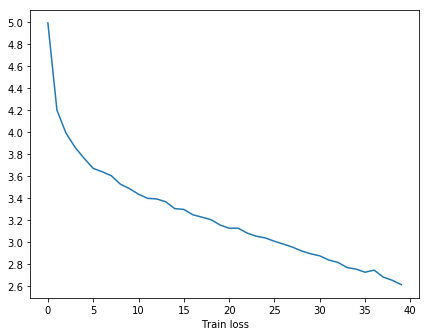

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

def showPlot(points):
    plt.figure(1,figsize=(10,8))
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('Train loss')
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.plot(points)
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=1.05)
    plt.show()

    showPlot(plot_losses)

# Define Evaluation

### Greedy searching

In [20]:
# Greedy decoding is the decoding method. For each time step,
# we simply choose the word from decoder_output with the highest softmax value.
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

### Evaluation functions

In [83]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Run Evaluation with Greedy search

In [29]:
 # Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting
evaluateInput(encoder, decoder, searcher, voc)

> You have my word. As a gentleman
Bot: you re a liar . s yours .
> She okay?
Bot: she s fine . s a seat .
> Where have you been?
Bot: i don t know . s a drink .
> Where have you been,Jay?
Bot: i don t know . s a drink .
> who?
Bot: the groom . s a friend .
> Why’d you call me?
Bot: i don t know . s a killer
> You’re drunk
Bot: i m not gonna be helpful . s
> great
Bot: you re a good man . s .
> there
Bot: what ? you know what i m saying ?
> Hi.
Bot: hi . s a good time .
> Have fun tonight?
Bot: no . s not here . s .
> Looks like things worked out tonight, huh?
Bot: yeah . s your wife . s
> sure?
Bot: sure . s your seat . s .
> did you change your hair?
Bot: no . s my mother . s
> no
Bot: you re a liar . s a killer
> q
